### Build A Basic Chatbot With Langgraph(GRAPH API)

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="openai/gpt-oss-20b")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000022D8D740380>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000022D8E833BF0>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [14]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000022D8E84C560>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000022D8E833E60>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [15]:
llm=init_chat_model("groq:openai/gpt-oss-20b")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000022D8EC3E960>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000022D8EC3F320>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [16]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [17]:
graph_builder=StateGraph(State)

## Adding node
graph_builder.add_node("llmchatbot",chatbot)
## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)


## compile the graph
graph=graph_builder.compile()

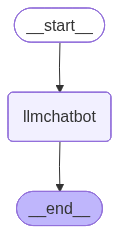

In [18]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [19]:
response=graph.invoke({"messages":"Hi"})

In [20]:
response["messages"][-1].content

'Hello! How can I help you today?'

In [21]:
for event in graph.stream({"messages":"Hi How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

Hello! I'm doing great—thanks for asking. How can I assist you today? Whether it's a web‑dev question, a JavaScript puzzle, or anything else, I'm here to help!


### Chatbot With Tool

In [22]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("Which women team won the cricket world cup in 2025?")

{'query': 'Which women team won the cricket world cup in 2025?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.olympics.com/en/news/women-odi-world-cup-2025-final-india-vs-south-africa-report',
   'title': "Women's Cricket World Cup 2025: India beat South Africa in final to ...",
   'content': "# Women's Cricket World Cup 2025: India make history, beat South Africa in final to win maiden title The **Indian cricket team** beat South Africa by 52 runs in the final to win the **Women’s ODI World Cup 2025** at the DY Patil Stadium in Navi Mumbai on Sunday. The run-a-ball 61-run partnership was ended by Deepti Sharma in the 40th over, leaving South Africa needing 88 in the final 10 overs with just four wickets in hand. **IND-W vs SA-W, Women's Cricket World Cup 2025 final brief scores**: India 298/7 in 50 overs (Shafali Verma 87, Deepti Sharma 58; Ayabonga Khaka 3/58) beat South Africa 246/10 in 45.3 overs (Laura Wolvaardt 101; Deepti Sharma

In [23]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [24]:
tools=[tool,multiply]

In [25]:
llm_with_tool=llm.bind_tools(tools)

In [26]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000022D8EC3E960>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000022D8EC3F320>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A l

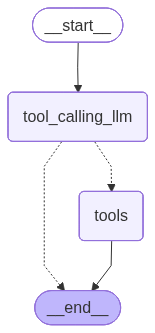

In [27]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))



In [28]:
response=graph.invoke({"messages":"What the gold price in India today?"})

In [29]:
response['messages'][-1].content

'{"query": "current gold price India today", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ts2.tech/en/gold-price-today-november-24-2025-spot-gold-near-4140-as-markets-bet-on-fed-rate-cut/", "title": "Gold Price Today, November 24, 2025: Spot Gold Near $4,140 as Markets Bet on Fed Rate Cut - ts2.tech", "score": 0.9997198, "published_date": "Tue, 25 Nov 2025 11:55:23 GMT", "content": "In parallel, geopolitical headlines — including ongoing efforts by the U.S. and Ukraine to reshape a peace proposal with Russia — continue to support gold’s safe‑haven appeal, even if Monday’s move was driven more by macroeconomics than by geopolitics. (\\n\\n## Gold price in India today (24 November 2025)\\n\\nWhile dollar‑denominated spot prices were firm, Indian gold prices actually fell on Monday, reflecting intraday global weakness and local market dynamics. [...] In India, benchmark gold futures and retail prices eased between about 0.7% and 1.2%, offering so

In [30]:
response=graph.invoke({"messages":"Multiply 60 and 58"})
response['messages'][-1].content

'3480'

In [31]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 60 and 58
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_051ecabd-ba7e-4383-b6c9-bfa399f70fd7)
 Call ID: fc_051ecabd-ba7e-4383-b6c9-bfa399f70fd7
  Args:
    a: 60
    b: 58
================================= Tool Message =================================
Name: multiply

3480


In [ ]:
response=graph.invoke({"messages":"What is 5 multiplied by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplied by 10
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_74422b1b-b891-4f95-b2bc-2cc937168c19)
 Call ID: fc_74422b1b-b891-4f95-b2bc-2cc937168c19
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: multiply

50


In [33]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_35f7ea86-99a5-4396-9fa7-18b0466d19b7)
 Call ID: fc_35f7ea86-99a5-4396-9fa7-18b0466d19b7
  Args:
    query: recent AI news 2025
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news 2025", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ts2.tech/en/openai-news-today-november-22-2025-foxconn-hardware-push-emirates-ai-deal-sam-altmans-memo-and-global-chatgpt-group-chats/", "title": "OpenAI News Today, November 22, 2025: Foxconn Hardware Push, Emirates AI Deal, Sam Altman’s Memo and Global ChatGPT Group Chats - ts2.tech", "score": 0.890761, "published_date": "Sat, 22 Nov 2025 14:41:53 GMT", "

### ReAct Agent Architecture

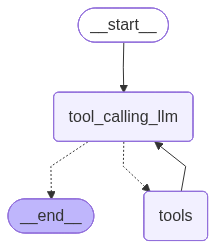

In [34]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 58 by 45"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 58 by 45
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_25815de9-d6fc-4a4c-b0b0-8bf9f59ec4aa)
 Call ID: fc_25815de9-d6fc-4a4c-b0b0-8bf9f59ec4aa
  Args:
    query: recent AI news 2025 November
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news 2025 November", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ts2.tech/en/openai-news-today-november-22-2025-foxconn-hardware-push-emirates-ai-deal-sam-altmans-memo-and-global-chatgpt-group-chats/", "title": "OpenAI News Today, November 22, 2025: Foxconn Hardware Push, Emirates AI Deal, Sam Altman’s Memo and Global ChatGPT Group Chats - ts2.tech", "score": 0.9168945, "published_date": "Sat, 22 Nov 2

## Adding Memory In Agentic Graph

In [37]:
response=graph.invoke({"messages":"Hello my name is Nilanjan"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is Nilanjan
================================== Ai Message ==================================

Hello Nilanjan! 👋 How can I assist you today?


In [38]:
response=graph.invoke({"messages":"What is my name?"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I’m sorry, but I don’t have that information. If you’d like, you can tell me your name and I’ll remember it for our conversation.


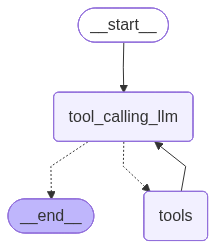

In [39]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"Hi my name is Nilanjan"},config=config)

response

{'messages': [HumanMessage(content='Hi my name is Nilanjan', additional_kwargs={}, response_metadata={}, id='163a8a90-67bd-4f78-9c57-d510cd449a4d'),
  AIMessage(content='Hello, Nilanjan! 👋 How can I help you today?', additional_kwargs={'reasoning_content': 'User says "Hi my name is Nilanjan". They likely want a greeting or conversation. We can respond politely, maybe ask how to help.'}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 351, 'total_tokens': 406, 'completion_time': 0.055785761, 'prompt_time': 0.023774391, 'queue_time': 0.139519628, 'total_time': 0.079560152, 'completion_tokens_details': {'reasoning_tokens': 31}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--67be3e55-f8d5-420e-907a-deec22a30cff-0', usage_metadata={'input_tokens': 351, 'output_tokens': 55, 'total_tokens': 406})]}

In [41]:
response['messages'][-1].content

'Hello, Nilanjan! 👋 How can I help you today?'

In [42]:
response=graph.invoke({"messages":"Hey what is my name"},config=config)

print(response['messages'][-1].content)

Your name is Nilanjan.


In [43]:
response=graph.invoke({"messages":"Hey do you remember my name"},config=config)

print(response['messages'][-1].content)

Yes, I remember—your name is Nilanjan.


### Streaming

In [44]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [45]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

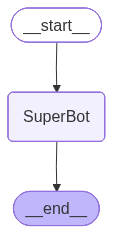

In [46]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)

graph_builder=graph.compile(checkpointer=memory)

## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [47]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Nilanjan And I like cricket"},config)

{'messages': [HumanMessage(content='Hi,My name is Nilanjan And I like cricket', additional_kwargs={}, response_metadata={}, id='975d0c43-16e8-4a16-8880-bf20d0c3f678'),
  AIMessage(content='Hey Nilanjan! 👋 Great to meet a fellow cricket fan. Which teams or players are you most into? Or maybe you’ve got a favorite match that still gets you excited? Let me know—happy to chat cricket (or anything else) with you!', additional_kwargs={'reasoning_content': 'The user says "Hi,My name is Nilanjan And I like cricket". They just introduced themselves and said they like cricket. We need to respond politely, perhaps ask about cricket preferences, teams, etc. We should keep the tone friendly. Also we can mention cricket topics. There\'s no instruction to do anything else. We should respond.'}, response_metadata={'token_usage': {'completion_tokens': 133, 'prompt_tokens': 83, 'total_tokens': 216, 'completion_time': 0.141936454, 'prompt_time': 0.009232213, 'queue_time': 0.047480286, 'total_time': 0.151

### Streaming 
Methods: .stream() and astream()

- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values** : This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.

In [48]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Nilanjan And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Hello, Nilanjan! 👋 Great to meet you. Cricket is such an exciting sport—do you have a favorite team or player? Or maybe you’re a fan of any particular format, like T20, ODIs, or Tests? Let me know!', additional_kwargs={'reasoning_content': 'User says: "Hi, My name is Nilanjan And I like cricket". They are greeting, introducing themselves. We should respond warmly. They also mention liking cricket. We can ask about cricket. There\'s no request. Just a greeting. We respond with a friendly reply, mention cricket.'}, response_metadata={'token_usage': {'completion_tokens': 123, 'prompt_tokens': 83, 'total_tokens': 206, 'completion_time': 0.127000582, 'prompt_time': 0.004660426, 'queue_time': 0.051925164, 'total_time': 0.131661008, 'completion_tokens_details': {'reasoning_tokens': 60}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider

In [49]:
for chunk in graph_builder.stream({'messages':"Hi,My name is Nilanjan And I like cricket"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Nilanjan And I like cricket', additional_kwargs={}, response_metadata={}, id='ca156d29-dc21-465a-b262-0f40697574d0'), AIMessage(content='Hello, Nilanjan! 👋 Great to meet you. Cricket is such an exciting sport—do you have a favorite team or player? Or maybe you’re a fan of any particular format, like T20, ODIs, or Tests? Let me know!', additional_kwargs={'reasoning_content': 'User says: "Hi, My name is Nilanjan And I like cricket". They are greeting, introducing themselves. We should respond warmly. They also mention liking cricket. We can ask about cricket. There\'s no request. Just a greeting. We respond with a friendly reply, mention cricket.'}, response_metadata={'token_usage': {'completion_tokens': 123, 'prompt_tokens': 83, 'total_tokens': 206, 'completion_time': 0.127000582, 'prompt_time': 0.004660426, 'queue_time': 0.051925164, 'total_time': 0.131661008, 'completion_tokens_details': {'reasoning_tokens': 60}}, 'model_name': 'openai

In [50]:
# Create a thread
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Nilanjan And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Hey Nilanjan! 👋 Great to meet another cricket fan. Who’s your favorite team or player? And are you more into batting, bowling, or just watching the game?', additional_kwargs={'reasoning_content': 'User says "Hi, My name is Nilanjan And I like cricket". We need to respond with a friendly greeting, maybe ask about cricket. According to policy, we can mention sports. It\'s fine. No policy violation. Should be engaging.'}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 83, 'total_tokens': 180, 'completion_time': 0.096852612, 'prompt_time': 0.005398384, 'queue_time': 0.047737926, 'total_time': 0.102250996, 'completion_tokens_details': {'reasoning_tokens': 51}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--2acf197f-4023-4353-93bc-963da5146c78-0', usage_metadata={'input_tokens': 

In [51]:
for chunk in graph_builder.stream({'messages':"I also like football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Nilanjan And I like cricket', additional_kwargs={}, response_metadata={}, id='ad69ceae-1768-4254-acbb-4ae2cea00326'), AIMessage(content='Hey Nilanjan! 👋 Great to meet another cricket fan. Who’s your favorite team or player? And are you more into batting, bowling, or just watching the game?', additional_kwargs={'reasoning_content': 'User says "Hi, My name is Nilanjan And I like cricket". We need to respond with a friendly greeting, maybe ask about cricket. According to policy, we can mention sports. It\'s fine. No policy violation. Should be engaging.'}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 83, 'total_tokens': 180, 'completion_time': 0.096852612, 'prompt_time': 0.005398384, 'queue_time': 0.047737926, 'total_time': 0.102250996, 'completion_tokens_details': {'reasoning_tokens': 51}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'service_tier': 'on_demand', 'finish_reason

In [52]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Nilanjan and I like to play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Nilanjan and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'de61f8a4-cadb-4e27-8b42-e2d9b5f674f6', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is Nilanjan and I like to play cricket', additional_kwargs={}, response_metadata={}, id='aac0b518-4569-4af4-b164-402baff2f601')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '1b9e2cbc-e7a0-472f-ac3d-5711bfc9bb04', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:7786757b-cac1-334f-1649-c249c1861394'}, 'parent_ids': ['de61f8a4-cadb-4e27-8b42-e2d9b5f674f6']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is Nilanjan and I li